# MNIST DIGIT RECOGNITION DATASET

In [23]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import cv2
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter

In [24]:
(Xtrain,ytrain), (Xtest,ytest) = keras.datasets.mnist.load_data()
print(ytrain)

[5 0 4 ... 5 6 8]


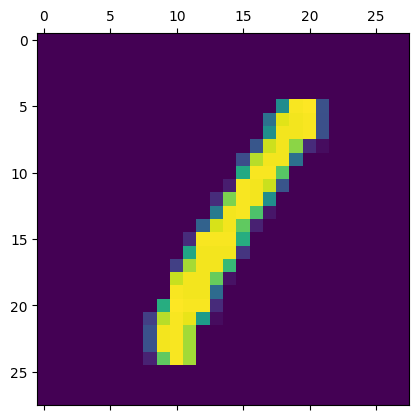

In [25]:
plt.matshow(Xtrain[3])

In [26]:
ytrain[3]

1

In [27]:
Xtrain.shape

(60000, 28, 28)

In [28]:
Xtrain=Xtrain/255
Xtest=Xtest/255
Xtrain_flat=Xtrain.reshape(len(Xtrain),28*28)
Xtest_flat=Xtest.reshape(len(Xtest),28*28)

In [29]:
Xtrain_flat.shape

(60000, 784)

In [30]:
Xtest_flat.shape

(10000, 784)

In [31]:
model=keras.Sequential([
    keras.layers.Dense(400,input_shape=(784,),activation='relu'),
    keras.layers.Dense(10,activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(Xtrain_flat,ytrain,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2054 - accuracy: 0.9393
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0829 - accuracy: 0.9752
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0537 - accuracy: 0.9831
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0386 - accuracy: 0.9875
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0282 - accuracy: 0.9909


In [14]:
model.evaluate(Xtest_flat,ytest) 

313/313 [==============================] - 1s 3ms/step - loss: 0.0673 - accuracy: 0.9779


[0.06725776940584183, 0.9779000282287598]

313/313 [==============================] - 1s 2ms/step


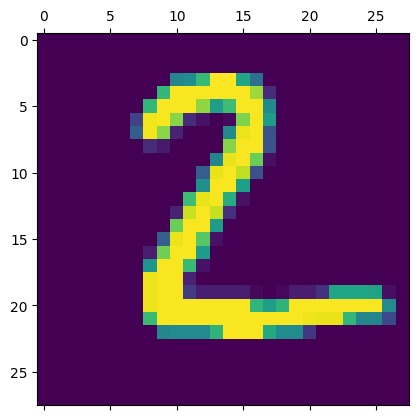

In [32]:
y_pred=model.predict(Xtest_flat)
y_pred_label=[np.argmax(i) for i in y_pred]
plt.matshow(Xtest[1])


[9.9997771e-01 2.3688042e-05 1.3065697e-01 3.2441505e-05 1.8650433e-02
 6.4033506e-05 7.6319861e-01 1.1002783e-02 3.6829300e-04 1.9481335e-02]
0


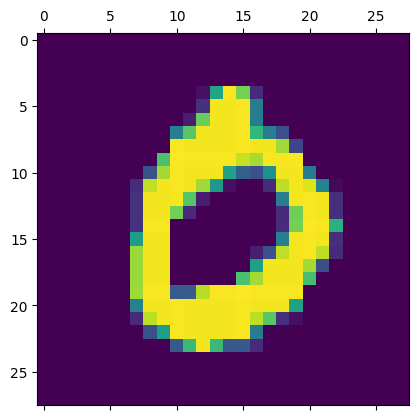

In [33]:
plt.matshow(Xtest[3])
print(y_pred[3])
print(y_pred_label[3])

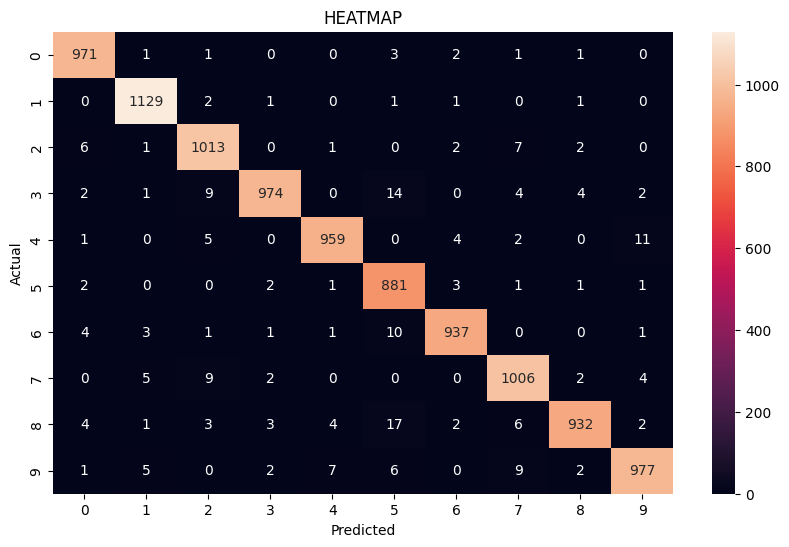

In [18]:
import seaborn as sns
plt.figure(figsize=(10,6))
cm=tf.math.confusion_matrix(labels=ytest,predictions=y_pred_label)
sns.heatmap(cm,annot=True,fmt='d')
plt.title('HEATMAP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
joblib.dump(model, 'final_model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2022-12-06 07:43:04         1423
metadata.json                                  2022-12-06 07:43:04           64
variables.h5                                   2022-12-06 07:43:04      3833992


['final_model.pkl']

In [35]:
def store_image(filename='EXAMPLE.jpg'):
    return cv2.imread(filename, 0)

Text(0.5, 1.0, 'Second')

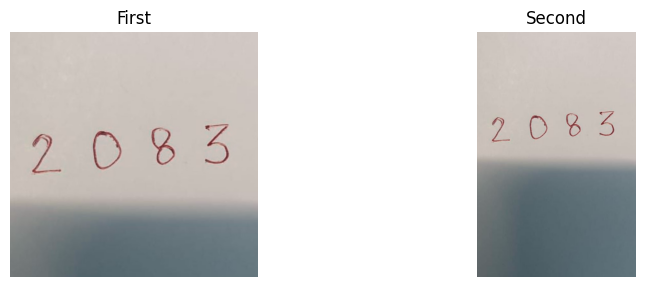

In [39]:
import cv2
from matplotlib import pyplot as plt
  
fig = plt.figure(figsize=(10, 7))
  
rows = 2
columns = 2

Image1 = cv2.imread('EXAMPLE.jpg')
Image2 = cv2.imread('example.jpeg')

fig.add_subplot(rows, columns, 1)
plt.imshow(Image1)
plt.axis('off')
plt.title("First")

fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Second")

In [31]:
def get_sample_image(filename='EXAMPLE.jpg'):
    return cv2.imread(filename, 0)


def binarize(img=get_sample_image()):
    thresh = cv2.adaptiveThreshold(img, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 4)
    return thresh


def show(img):
    import matplotlib.pyplot as plt
    plt.imshow(img, cmap=plt.cm.binary)
    


def find_digits(binary_img):
    inv = cv2.bitwise_not(binary_img)
    contours, hierarchy = cv2.findContours(inv,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    digits = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 500:
            [x, y, w, h] = cv2.boundingRect(cnt)
            margin = 20
            x -= margin
            y -= margin
            w += margin*2
            h += margin*2

            figure = binary_img[y: y + h, x: x + w]
            if figure.size > 0:
                digits.append({
                    'image': figure,
                    'x': x,
                    'y': y,
                    'w': w,
                    'h': h,
                })
    return digits



def resize_digits(digits):
    digits = map(itemgetter('image'), sorted(digits, key=itemgetter('x')))
    blur_kernel = np.ones((4, 4), np.float32)/(4*4)
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    return [
        cv2.resize(
            cv2.bitwise_not(
                cv2.filter2D(
                    cv2.erode(digit, erode_kernel, iterations=1),
                    -1, blur_kernel)
            ),
            (20, 20))
        for digit in digits]


def insert_into_center(resized_digits):
    results = []
    for img in resized_digits:
        i = np.zeros((28, 28))
        # calculate center of mass of the pixels
        M = cv2.moments(img)
        try:
            xc = M['m10'] / M['m00']
            yc = M['m01'] / M['m00']
        except ZeroDivisionError:
            xc = 10
            yc = 10

        # translating the image so as to position
        # this point at the center of the 28x28 field.
        start_a = max(min(4 + (10 - int(yc)), 8), 0)
        start_b = max(min(4 + (10 - int(xc)), 8), 0)
        i[start_a:start_a+20, start_b:start_b+20] = img

        results.append(i)
    return results


In [57]:
def draw_contours(frame, contours):
    for img in contours:
        cv2.rectangle(
            frame,
            (img['x'], img['y']),
            (img['x'] + img['w'], img['y'] + img['h']),
            (0, 0, 0),
            4
        )


def preprocess(digits):
    return np.vstack([digit.reshape(28*28).astype(np.float)/255
                      for digit in digits])

def static_image_ocr():
    frame = get_sample_image()
    contours = find_digits(binarize(frame.copy()))
    draw_contours(frame, contours)
    digits = insert_into_center(resize_digits(contours))
    X = preprocess(digits)
    y_pred_X = model.predict(X)
    y_pred_label_X = [np.argmax(i) for i in y_pred_X]
    plt.matshow(frame)
    plt.matshow(binarize(frame.copy()))
#     plt.imshow(np.hstack(tuple(digits)),cmap = plt.cm.binary)
    print('OUTPUT GENERATED THROUGH OCR IS : ',y_pred_label_X)

1/1 [==============================] - 0s 21ms/step


C:\Users\91844\AppData\Local\Temp\ipykernel_11528\2670668450.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.vstack([digit.reshape(28*28).astype(np.float)/255


OUTPUT GENERATED THROUGH OCR IS :  [2, 0, 8, 3]


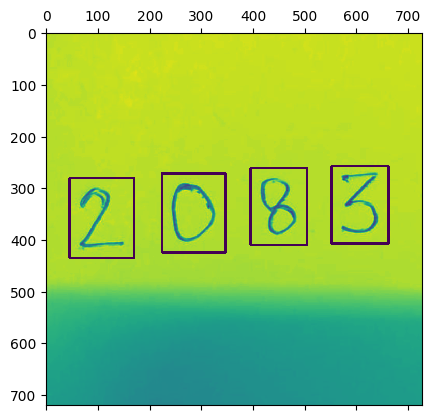

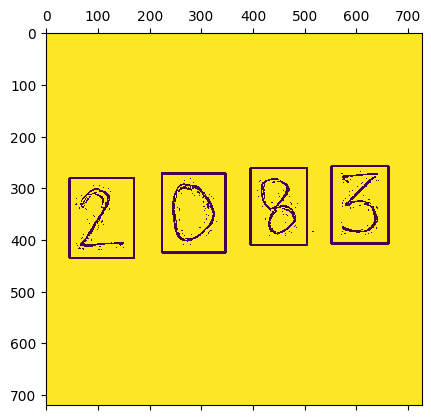

In [58]:
static_image_ocr()